# Dependencies

In [1]:
import sys
import os


!pip install torch torchvision torchaudio

# Install packages within the virtual environment
!pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  torch-cluster \
  torch-spline-conv \
  -f https://pytorch-geometric.com/whl/torch-2.5.1%2Bcu124.html # or your specific torch and cuda version

!pip install ogb

!pip install numpy matplotlib networkx scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

# Testing

In [ ]:
import torch
import torch_geometric

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")

# Test a simple graph creation
from torch_geometric.data import Data

# Create a simple graph with 3 nodes and 4 edges
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[1], [2], [3]], dtype=torch.float)  # Node features

graph = Data(x=x, edge_index=edge_index)
print(f"Graph created successfully: {graph}")
print(f"Number of nodes: {graph.num_nodes}")
print(f"Number of edges: {graph.num_edges}")
print(f"Is the graph directed? {graph.is_directed()}")


PyTorch version: 2.5.1+cu124
PyTorch Geometric version: 2.6.1
Graph created successfully: Data(x=[3, 1], edge_index=[2, 4])
Number of nodes: 3
Number of edges: 4
Is the graph directed? False


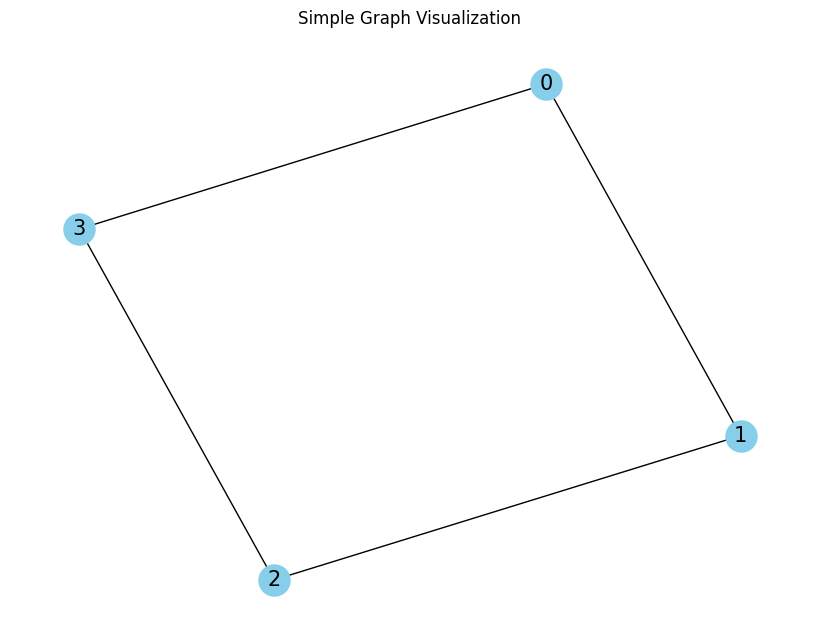

Input features shape: torch.Size([4, 1])
Output features shape: torch.Size([4, 1])
Output features:
tensor([[0.3202],
        [0.3469],
        [0.3736],
        [0.4003]], grad_fn=<AddBackward0>)


In [ ]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import networkx as nx

# Create a simple graph
edge_index = torch.tensor([[0, 1, 1, 2, 2, 3, 3, 0],
                           [1, 0, 2, 1, 3, 2, 0, 3]], dtype=torch.long)
x = torch.tensor([[0], [1], [2], [3]], dtype=torch.float)
graph = Data(x=x, edge_index=edge_index)

# Visualize the graph using NetworkX
def visualize_graph(graph_data):
    G = nx.Graph()
    for i in range(graph_data.num_nodes):
        G.add_node(i)

    edge_list = graph_data.edge_index.t().numpy().tolist()
    for edge in edge_list:
        G.add_edge(edge[0], edge[1])

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='skyblue',
            node_size=500, edge_color='black', linewidths=1, font_size=15)
    plt.title("Simple Graph Visualization")
    plt.show()

# Visualize the graph
visualize_graph(graph)

# Define a simple GNN layer
class SimpleGNN(torch.nn.Module):
    def __init__(self):
        super(SimpleGNN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Test the GNN
model = SimpleGNN()
output = model(graph.x, graph.edge_index)
print(f"Input features shape: {graph.x.shape}")
print(f"Output features shape: {output.shape}")
print(f"Output features:\n{output}")


# 2.1: Loading and exploring OGB datasets

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator as NodeEvaluator
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator as GraphEvaluator

# Load node classification dataset (ogbn-arxiv)
node_dataset = PygNodePropPredDataset(name="ogbn-arxiv", transform=T.ToSparseTensor())
node_data = node_dataset[0]
node_data.adj_t = node_data.adj_t.to_symmetric() # Make the adjacency matrix symmetric
node_split_idx = node_dataset.get_idx_split()

# Load graph classification dataset (ogbg-molhiv)
graph_dataset = PygGraphPropPredDataset(name="ogbg-molhiv")
graph_split_idx = graph_dataset.get_idx_split()

# -------------------------------------------------------------

# exploring ogbn-arxiv

# 1. number of nodes and in ogbn-arxiv?
print(f"Number of nodes: {node_data.num_nodes}")
print(f"Number of edges: {node_data.num_edges}")

# 2. number of dimensions in ogbn-arxiv?
print(f"Number of dimensions: {node_data.num_node_features}")

# 3. number of classes in ogbn-arxiv?
print(f"Number of classes: {node_dataset.num_classes}")

# 4. what is the label (class) of the node with index 1000 in ogbn-arxiv?
print(f"Label of node 1000: {node_data.y[1000]}")

# exploring ogbg-molhiv

# 5. how many graphs in ogbg-molhiv?
print(f"Number of graphs: {len(graph_dataset)}")

# 6. what is the number of nodes and edges in the graph with index 100 in ogbg-molhiv?
graph_data = graph_dataset[100]
print(f"Number of nodes in graph 100: {graph_data.num_nodes}")
print(f"Number of edges in graph 100: {graph_data.num_edges}")

# 7. what is the label of the graph with index 100 in ogbg-molhiv?
print(f"Label of graph 100: {graph_data.y}")

# 8. is the ogbg-molhiv dataset of type regression or classification?
print(f"Dataset type: {graph_dataset.task_type}")

# 9. evluation metric used for the dataset ogbg-molhiv?
print(f"Evaluation metric: {graph_dataset.eval_metric}")



/usr/local/lib/python3.11/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

Number of nodes: 169343
Number of edges: 2315598
Number of dimensions: 128
Number of classes: 40
Label of node 1000: tensor([4])
Number of graphs: 41127
Number of nodes in graph 100: 22
Number of edges in graph 100: 42
Label of graph 100: tensor([[0]])
Dataset type: binary classification
Evaluation metric: rocauc


/usr/local/lib/python3.11/dist-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed

# 2.2: GCN Implementation for Node Classification

/usr/local/lib/python3.11/dist-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_

Epoch: 010, Loss: 1.9501, Train: 0.5935, Val: 0.6143, Test: 0.6210, Time: 0.97s, LR: 0.001000
Epoch: 020, Loss: 1.7940, Train: 0.6337, Val: 0.6410, Test: 0.6415, Time: 0.98s, LR: 0.000999
Epoch: 030, Loss: 1.7120, Train: 0.6608, Val: 0.6629, Test: 0.6676, Time: 0.99s, LR: 0.000998
Epoch: 040, Loss: 1.6603, Train: 0.6776, Val: 0.6725, Test: 0.6781, Time: 0.99s, LR: 0.000996
Epoch: 050, Loss: 1.6208, Train: 0.6910, Val: 0.6785, Test: 0.6844, Time: 0.98s, LR: 0.000994
Epoch: 060, Loss: 1.5887, Train: 0.7044, Val: 0.6831, Test: 0.6892, Time: 0.98s, LR: 0.000991
Epoch: 070, Loss: 1.5618, Train: 0.7160, Val: 0.6878, Test: 0.6923, Time: 0.97s, LR: 0.000988
Epoch: 080, Loss: 1.5425, Train: 0.7255, Val: 0.6911, Test: 0.6958, Time: 0.97s, LR: 0.000984
Epoch: 090, Loss: 1.5181, Train: 0.7358, Val: 0.6930, Test: 0.6937, Time: 0.97s, LR: 0.000980
Epoch: 100, Loss: 1.4996, Train: 0.7447, Val: 0.6938, Test: 0.6951, Time: 0.98s, LR: 0.000976
Epoch: 110, Loss: 1.4804, Train: 0.7523, Val: 0.6981, Test: 

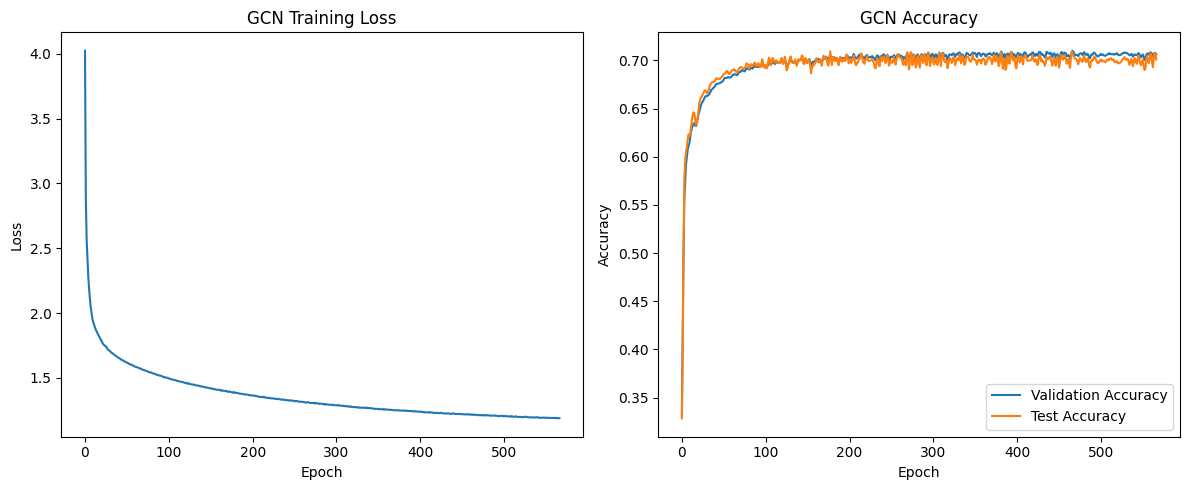

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from torch_geometric.nn import GCNConv
from torch_geometric.data import NeighborSampler
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
from torch_sparse import SparseTensor

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout, residual=True):
        super(GCN, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout
        self.residual = residual

        # input projection
        self.input_proj = nn.Linear(in_channels, hidden_channels)

        # GCN layers
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.layer_norms = nn.ModuleList()

        # first GCN layer
        self.convs.append(GCNConv(hidden_channels, hidden_channels, cached=True, normalize=True))
        self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

        self.layer_norms.append(nn.LayerNorm(hidden_channels))

        # hHidden GCN layers
        for i in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels, cached=True, normalize=True))
            self.batch_norms.append(nn.BatchNorm1d(hidden_channels))

            self.layer_norms.append(nn.LayerNorm(hidden_channels))

        # output layer
        self.convs.append(GCNConv(hidden_channels, hidden_channels, cached=True, normalize=True))

        # output projection
        self.output_proj = nn.Linear(hidden_channels, out_channels)

        # layer-wise dropout rates
        self.dropout_rates = [dropout * (1.0 - 0.1 * min(i, 5)) for i in range(num_layers)]

    def forward(self, x, edge_index):
        # input projection
        x = self.input_proj(x)
        x = F.dropout(x, p=0.1, training=self.training)

        # process through GCN layers with residual connections
        for i in range(self.num_layers - 1):
            # Store original for residual connection
            x_res = x

            # apply GCN layer
            x = self.convs[i](x, edge_index)
            x = self.batch_norms[i](x)

            # apply residual connection if dimensions match
            if self.residual:
                x = x + x_res

            # apply layer norm and activation
            x = self.layer_norms[i](x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout_rates[i], training=self.training)

        # final GCN layer
        x_res = x
        x = self.convs[-1](x, edge_index)

        # residual connection for final layer
        if self.residual:
            x = x + x_res

        # output projection
        x = self.output_proj(x)

        return x

def preprocess_data(data):
    # Z-score normalization
    mean = data.x.mean(dim=0, keepdim=True)
    std = data.x.std(dim=0, keepdim=True) + 1e-6
    data.x = (data.x - mean) / std

    # edge_index to SparseTensor for faster computation
    row, col = data.edge_index
    adj_t = SparseTensor(row=row, col=col, sparse_sizes=(data.num_nodes, data.num_nodes))

    adj_t = adj_t.set_diag()
    data.adj_t = adj_t

    return data

def load_dataset():
    # load ogbn-arxiv dataset
    dataset = PygNodePropPredDataset(name='ogbn-arxiv')
    data = dataset[0]

    # preprocess the data
    data = preprocess_data(data)

    split_idx = dataset.get_idx_split()
    train_idx = split_idx['train']
    valid_idx = split_idx['valid']
    test_idx = split_idx['test']

    return dataset, data, train_idx, valid_idx, test_idx

def train(model, data, train_idx, optimizer, device, edge_dropout=0.0):
    model.train()

    optimizer.zero_grad()

    # edge dropout for regularization
    if edge_dropout > 0 and model.training:
        adj_t = data.adj_t.to(device)
        edge_mask = torch.rand(adj_t.nnz()) > edge_dropout
        adj_t_dropout = adj_t.masked_select_nnz(edge_mask, layout='coo')
    else:
        adj_t_dropout = data.adj_t.to(device)

    # forward pass
    out = model(data.x.to(device), adj_t_dropout)

    # compute loss with label smoothing
    targets = data.y.squeeze(1)[train_idx].to(device)
    loss = F.cross_entropy(out[train_idx], targets, label_smoothing=0.1)

    # L2 regularization
    l2_reg = 0.0
    for param in model.parameters():
        l2_reg += torch.norm(param, 2)
    loss += 1e-5 * l2_reg

    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    return loss.item()

@torch.no_grad()
def test(model, data, split_idx, evaluator, device):
    model.eval()

    out = model(data.x.to(device), data.adj_t.to(device))

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']].to(device),
        'y_pred': y_pred[split_idx['train']], })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']].to(device),
        'y_pred': y_pred[split_idx['valid']], })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']].to(device),
        'y_pred': y_pred[split_idx['test']], })['acc']

    return train_acc, valid_acc, test_acc

def plot_learning_curves(train_losses, val_accuracies, test_accuracies, model_name='GCN'):
    plt.figure(figsize=(12, 5))

    # training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Training Loss')

    # validation and test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_learning_curves.png')
    plt.show()

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # seeds for reproducibility
    torch.manual_seed(42)

    # load dataset
    dataset, data, train_idx, valid_idx, test_idx = load_dataset()
    evaluator = Evaluator(name='ogbn-arxiv')

    # move data to device
    data = data.to(device)
    train_idx = train_idx.to(device)
    valid_idx = valid_idx.to(device)
    test_idx = test_idx.to(device)

    # hyperparameters
    hidden_channels = 512
    num_layers = 4
    dropout = 0.2
    lr = 0.001
    weight_decay = 0.0001
    epochs = 1000
    patience = 100
    edge_dropout = 0.05    # edge dropout for regularization

    # Initialize model
    model = GCN(
        in_channels=data.x.size(-1),
        hidden_channels=hidden_channels,
        out_channels=dataset.num_classes,
        num_layers=num_layers,
        dropout=dropout,
        residual=True
    ).to(device)

    # initialize optimizer with scheduling
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # cosine annealing scheduler for better convergence
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    # tracking variables
    best_val_acc = 0
    final_test_acc = 0
    best_epoch = 0
    epochs_without_improvement = 0


    train_losses = []
    val_accuracies = []
    test_accuracies = []
    # training loop
    for epoch in range(1, epochs + 1):
        start_time = time.time()

        # train
        loss = train(model, data, train_idx, optimizer, device, edge_dropout=edge_dropout)
        train_losses.append(loss)

        # evaluate
        split_idx = {'train': train_idx, 'valid': valid_idx, 'test': test_idx}
        train_acc, val_acc, test_acc = test(model, data, split_idx, evaluator, device)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)

        # update learning rate scheduler
        scheduler.step()

        epoch_time = time.time() - start_time

        # print results every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
                  f'Val: {val_acc:.4f}, Test: {test_acc:.4f}, Time: {epoch_time:.2f}s, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

        # check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            final_test_acc = test_acc
            best_epoch = epoch
            epochs_without_improvement = 0

        else:
            epochs_without_improvement += 1

        # early stopping
        if epochs_without_improvement >= patience:
            print(f'Early stopping after {epoch} epochs without improvement')
            break

    # final evaluation
    split_idx = {'train': train_idx, 'valid': valid_idx, 'test': test_idx}
    train_acc, val_acc, test_acc = test(model, data, split_idx, evaluator, device)

    print(f'Best model from epoch {best_epoch}:')
    print(f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

    # learning curves
    plot_learning_curves(train_losses, val_accuracies, test_accuracies, model_name='GCN')

if __name__ == "__main__":
    main()

# 2.3 GNN for Graph-Level Prediction

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GINConv, BatchNorm, global_add_pool, global_mean_pool, global_max_pool, GlobalAttention
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator

class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.conv = GCNConv(in_dim, out_dim, add_self_loops=True)
        self.bn = BatchNorm(out_dim)

    def forward(self, x, edge_index, edge_attr=None):
        x = self.conv(x, edge_index)
        x = self.bn(x)
        x = F.relu(x)
        return x


class SAGELayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.conv = SAGEConv(in_dim, out_dim)
        self.bn = BatchNorm(out_dim)

    def forward(self, x, edge_index, edge_attr=None):
        x = self.conv(x, edge_index)
        x = self.bn(x)
        x = F.relu(x)
        return x

class GINLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim)
        )
        self.conv = GINConv(self.mlp)
        self.bn = BatchNorm(out_dim)

    def forward(self, x, edge_index, edge_attr=None):
        x = self.conv(x, edge_index)
        x = self.bn(x)
        x = F.relu(x)
        return x



class GNNGraphPrediction(nn.Module):
    def __init__(
        self,
        num_node_features,
        hidden_dim=64,
        num_layers=3,
        pooling=None,
        gnn_type=None,
        dropout=0.5,
        num_tasks=1
    ):
        super().__init__()
        self.num_layers = num_layers
        self.pooling = pooling
        self.dropout = dropout

        GNNLayerClass = {
            "GCN": GCNLayer,
            "SAGE": SAGELayer,
            "GIN": GINLayer }[gnn_type]

        # constructing the layers
        self.layers = nn.ModuleList()
        self.layers.append(GNNLayerClass(num_node_features, hidden_dim))

        for i in range(num_layers - 1):
            self.layers.append(GNNLayerClass(hidden_dim, hidden_dim))

        # pooling
        if pooling == "attention":
            # GlobalAttention needs a gate neural network to compute attention scores
            self.att_gate_nn = nn.Sequential(nn.Linear(hidden_dim, 1))
            self.pool = GlobalAttention(gate_nn=self.att_gate_nn)
        else:
            self.pool = None  # sum, mean, or max is handled manually


        # final prediction MLP
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=self.dropout),
            nn.Linear(hidden_dim, num_tasks)
        )

    def forward(self, x, edge_index, batch, edge_attr=None):
        # apply each GNN layer
        for layer in self.layers:
            x = layer(x, edge_index, edge_attr=edge_attr)

        # pool to obtain a graph-level embedding
        if self.pooling == "sum":
            g_emb = global_add_pool(x, batch)
        elif self.pooling == "mean":
            g_emb = global_mean_pool(x, batch)
        elif self.pooling == "max":
            g_emb = global_max_pool(x, batch)
        elif self.pooling == "attention":
            g_emb = self.pool(x, batch) # GlobalAttention layer

        # predict graph property
        out = self.mlp(g_emb)
        return out



def train(model, device, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()

        # data.x.float for sage
        out = model(data.x.float(), data.edge_index, data.batch, data.edge_attr)
        y = data.y.float()

        loss = loss_fn(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(loader.dataset)


@torch.no_grad()
def eval(model, device, loader, evaluator):
    model.eval()
    y_true = []
    y_pred = []
    for data in loader:
        data = data.to(device)
        # data.x.float for sage
        out = model(data.x.float(), data.edge_index, data.batch, data.edge_attr)
        y_true.append(data.y.view(-1, 1))
        y_pred.append(out.view(-1, 1))

    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)

    # "rocauc" from ogb.graphproppred evaluator for binary classification
    input_dict = {"y_true": y_true, "y_pred": y_pred}
    result_dict = evaluator.eval(input_dict)
    return result_dict["rocauc"]


def main():
    dataset = PygGraphPropPredDataset(name="ogbg-molhiv")

    # splitting dataset into train, valid, and test
    split_idx = dataset.get_idx_split()
    train_dataset = dataset[split_idx["train"]]
    valid_dataset = dataset[split_idx["valid"]]
    test_dataset = dataset[split_idx["test"]]

    # dataLoaders for faster processing
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # num of node features
    in_dim = dataset.num_node_features
    num_tasks = dataset.num_tasks


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # model creation with its hyperparameters
    model = GNNGraphPrediction(
        num_node_features=in_dim,
        hidden_dim=64,
        num_layers=3,
        pooling="sum",   # "sum", "mean", "max", "attention"
        gnn_type="GCN",  # "GCN", "SAGE", "GIN"
        dropout=0.5,
        num_tasks=num_tasks
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    loss_fn = nn.BCEWithLogitsLoss()

    evaluator = Evaluator(name="ogbg-molhiv")


    best_val_rocauc = 0
    best_test_rocauc = 0
    epochs = 50

    # training
    for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, loss_fn)
        val_rocauc = eval(model, device, valid_loader, evaluator)
        test_rocauc = eval(model, device, test_loader, evaluator)

        if val_rocauc > best_val_rocauc:
            best_val_rocauc = val_rocauc
            best_test_rocauc = test_rocauc


        print(f"Epoch {epoch:02d}, " f"Train Loss: {train_loss:.4f}, " f"Val ROC-AUC: {val_rocauc:.4f}, "f"Test ROC-AUC: {test_rocauc:.4f}")

    print("Training done!")
    print(f"Best validation ROC-AUC: {best_val_rocauc:.4f}")
    print(f"Test ROC-AUC (corresponding to best val): {best_test_rocauc:.4f}")


if __name__ == "__main__":
    main()


Downloaded 0.00 GB: 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]
Processing...


Extracting dataset/hiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 41127/41127 [00:00<00:00, 117254.94it/s]


Converting graphs into PyG objects...


100%|██████████| 41127/41127 [00:01<00:00, 27393.39it/s]


Saving...


Done!
/usr/local/lib/python3.11/dist-packages/ogb/graphproppred/dataset_pyg.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.pro

Epoch 01, Train Loss: 0.2115, Val ROC-AUC: 0.6068, Test ROC-AUC: 0.5735
Epoch 02, Train Loss: 0.1727, Val ROC-AUC: 0.6196, Test ROC-AUC: 0.5838
Epoch 03, Train Loss: 0.1609, Val ROC-AUC: 0.6320, Test ROC-AUC: 0.6236
Epoch 04, Train Loss: 0.1556, Val ROC-AUC: 0.6630, Test ROC-AUC: 0.6707
Epoch 05, Train Loss: 0.1529, Val ROC-AUC: 0.6464, Test ROC-AUC: 0.6720
Epoch 06, Train Loss: 0.1483, Val ROC-AUC: 0.6732, Test ROC-AUC: 0.6326
Epoch 07, Train Loss: 0.1482, Val ROC-AUC: 0.6903, Test ROC-AUC: 0.6443
Epoch 08, Train Loss: 0.1438, Val ROC-AUC: 0.7075, Test ROC-AUC: 0.6980
Epoch 09, Train Loss: 0.1438, Val ROC-AUC: 0.6285, Test ROC-AUC: 0.6251
Epoch 10, Train Loss: 0.1434, Val ROC-AUC: 0.7101, Test ROC-AUC: 0.6956
Epoch 11, Train Loss: 0.1411, Val ROC-AUC: 0.6243, Test ROC-AUC: 0.6455
Epoch 12, Train Loss: 0.1395, Val ROC-AUC: 0.6656, Test ROC-AUC: 0.6450
Epoch 13, Train Loss: 0.1383, Val ROC-AUC: 0.7041, Test ROC-AUC: 0.6782
Epoch 14, Train Loss: 0.1394, Val ROC-AUC: 0.6614, Test ROC-AUC: